In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.sparse as sps

import jlinops
import sampi

In [2]:
from fastprogress import progress_bar

from runningstatistics import StatsTracker

In [3]:

class CGLSGaussianModSampler:
    """Represents a Gaussian sampler for Gaussians of the form
    -log \pi(x) = \sum_i^K (1/2)|| L_i x - s_i ||_2^2 + C.
    
    """
    
    def __init__(self, factors, shifts):
        
        self.factors = factors
        self.shifts = shifts
            
        # Checks
        self.n = self.factors[0].shape[1]
        for factor in self.factors[1:]:
            assert factor.shape[1] == self.n, "incompatible shapes for factors."
        
        # Set None shifts to zeros
        for j in range(len(self.shifts)):
            if self.shifts[j] is None:
                self.shifts[j] = np.zeros(self.factors[j].shape[0])
                
        # Assemble matrix
        self.A = jlinops.StackedOperator(self.factors)
        self.m = self.A.shape[0]
        
        # Assemble deterministic part of rhs
        self.rhs_det = np.hstack(self.shifts)
        
        
    def sample(self, n_samples=100, warmstarting=False, observables=None, *args, **kwargs):
        
        # Instantiate tracker
        tracker = StatsTracker((self.n,))
        
        # Setup
        init = None
        n_cg_its_per_sample = []
        if observables is None:
            pass
        else:
            n_observables = len(observables)
            obs_trackers = []
            for i, observable in enumerate(observables):
                # Instantiate tracker for each observable
                tmp = observable(np.ones(self.n)) # figure out array shape of the output
                if np.isscalar(tmp):
                    obs_tracker = StatsTracker((1,))
                    obs_trackers.append(obs_tracker)
                else:
                    obs_tracker = StatsTracker(tmp.shape)
                    obs_trackers.append(obs_tracker)

        all_vars = []
        
        # Generate samples
        for j in range(n_samples):
            
            # Generate random part of rhs
            rhs_rand = np.random.normal(size=self.m)
            
            # Sum together
            rhs = self.rhs_det + rhs_rand
            
            # Solve the random least-squares problem
            cgls_solve = jlinops.cgls(self.A, rhs, x0=init, *args, **kwargs)
            sample = cgls_solve["x"]
            n_cg_its_per_sample.append( cgls_solve["n_iters"] )
            if warmstarting: 
                init = sample
            tracker.push(sample)
            
            # Get current variance estimate
            if j > 1:
                all_vars.append(tracker.variance())

            # Handle any observables
                if observables is not None:
                    for i in range(n_observables):
                        obs_trackers[i].push(sample)
                    
            
        data = {
            "mean": tracker.mean(),
            "stdev": tracker.stdev(),
            "var": tracker.variance(),
            "n_cg_its_per_sample": np.asarray(n_cg_its_per_sample),
            "tracker": tracker,
            "obs_trackers": None,
            "all_vars": np.vstack(all_vars)
        }
                                        
        if observables is not None:
            data["obs_trackers"] = obs_trackers
        
        return data


# Toy problem

In [4]:
ground_truth = jlinops.piecewise_constant_1d_test_problem()
n = len(ground_truth)
np.random.seed(0)
noise_stdev = 0.15
noise_var = noise_stdev**2
noisy_signal = ground_truth + noise_stdev*np.random.normal(size=n)
grid = np.arange(n)

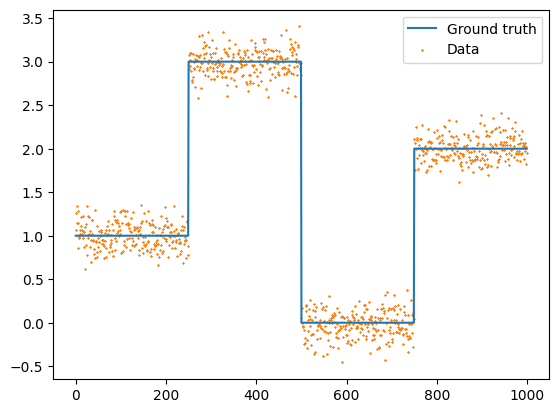

In [5]:
plt.plot(grid, ground_truth, label="Ground truth", color="C0")
plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
plt.legend()
plt.show()

In [6]:
# Define forward operator and regularization matrix
F = jlinops.IdentityOperator((n,n))
Rmat, Wmat = jlinops.first_order_derivative_1d(n, boundary="none")
RhRmat = Rmat.multiply(Rmat)
W = jlinops.MatrixLinearOperator(Wmat)
R = jlinops.MatrixLinearOperator(Rmat)
RhR = jlinops.MatrixLinearOperator(RhRmat)

In [83]:
sampler = CGLSGaussianModSampler([F, R], shifts=[None,None])

In [93]:
sresults = sampler.sample(n_samples=2000)

In [95]:
np.vstack(sresults["all_vars"]).shape

(1998, 1000)

In [100]:
sresults["all_vars"].shape

(1998, 1000)

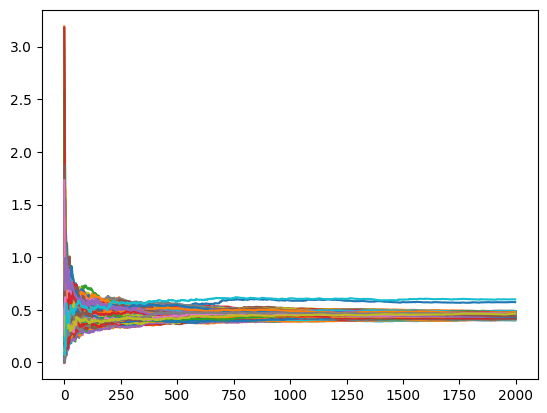

In [98]:
plt.plot(sresults["all_vars"][:,:])
plt.show()

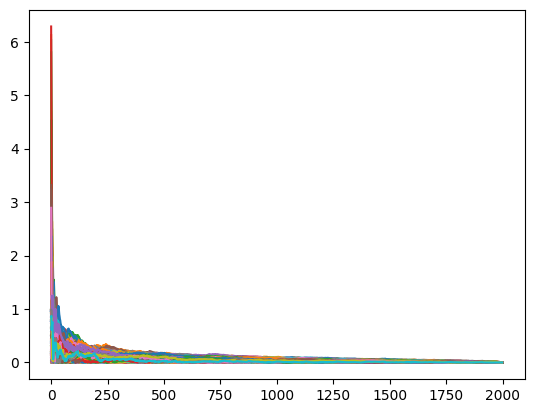

In [103]:
plt.plot( (np.abs(sresults["all_vars"][:,:] - np.repeat(sresults["all_vars"][-1,:][:,None], 1998 ,axis=1 ).T)/np.repeat(sresults["all_vars"][-1,:][:,None], 1998 ,axis=1 ).T   ))
plt.show()

# IAS plus solver?

In [70]:
from scipy.integrate import odeint
from scipy.sparse.linalg import aslinearoperator
# import scipy.sparse as sps


class IASPlusSolver:

    def __init__(self, F, R, y, RhR, hyperparams, noise_var=None, pdata={}):

        # Bind
        self.F = F
        self.y = y
        self.noise_var = noise_var
        self.R = R
        self.RhR = RhR
        self.hyperparams = hyperparams
        assert noise_var is not None, "Must fix noise_var for now!"
    
        # Some checks
        assert self.F.shape[1] == self.R.shape[1], "Shapes of forward and regularization operators do not agree!"
       
        if not np.isscalar(self.hyperparams["prior"]["vartheta"]):
            assert len(self.hyperparams["prior"]["vartheta"]) == self.R.shape[0], "If vartheta is a vector, must be same size as output size of regularization operator."

        assert not ( ( "noise_var" in self.hyperparams.keys() ) and ( noise_var is not None ) ), "Leave noise_var=None if specifying a hyperprior for the noise variance."
        
        # Handle pdata
        self._pdata = pdata
        self.pdata = {
            "W": None,
            "Rpinv_factory": None,
            "Rinv": None,
            "FWpinv": None,
        }
        for key in self._pdata.keys():
            if key in ["W", "Rpinv_factory", "Rinv", "FWpinv"]:
                self.pdata[key] = self._pdata[key]
            else:
                raise ValueError
        
        # Some others
        self.n = self.F.shape[1] # dimension of the unknown
        self.m = self.F.shape[0] # output size of forward operator
        self.k = self.R.shape[0] # output size of regularization operator
        
        if noise_var is None:
            self.updating_noise_var = True
        else:
            self.updating_noise_var = False

        if self.pdata["W"] is not None:
            self.pdata["FW_pinv"] = jlinops.QRPinvOperator( jlinops.MatrixLinearOperator(self.F.matmat(self.pdata["W"].A)) )
      
        # Misc
        self.last_x = None
        self.last_xbar = None



    def solve(self, max_iters=100, post_cov_samples=25, x0=None, priorconditioning=False, x_update_solver_params={}, eps=1e-2, early_stopping=True, warmstarting=True):
        """Driver for the IAS solver.
        """

        # Handle noise var
        if self.updating_noise_var:
            noise_var_curr = 1.0
        else:
            noise_var_curr = self.noise_var
        
        # Handle initialization
        if x0 is None:
            x = np.ones(self.n)
        else:
            x = x0
        
        # Handle warmstarting
        if warmstarting:
            x_prev = x.copy()
        else:
            x_prev = None

        # Tracking
        n_cg_its_per_iteration = []
        obj_vals = []
        noise_vars = []
        converged = False
        n_iters = 0

        # Estimate theta
        theta = np.ones(self.R.shape[0])
        diag_post_cov_ests = []
        RhR_diag_post_cov_ests = []
    
        # Iterate
        for j in progress_bar(range(max_iters)):
            
            # Update noise variance
            if self.updating_noise_var:
                noise_var_curr = self.noise_var_update(x)
            noise_vars.append(noise_var_curr)

            # Get new estimate of diagonal of posterior covariance
            Ftilde = (1.0/noise_stdev)*self.F.T
            Rtilde = jlinops.DiagonalOperator(1.0/np.sqrt(theta)) @ self.R
            sampler = CGLSGaussianModSampler([ Ftilde, Rtilde], shifts=[None,None])
            sresults = sampler.sample(n_samples=post_cov_samples)
            diag_post_cov_est = sresults["var"]
            diag_post_cov_ests.append(diag_post_cov_est)
            RhR_diag_post_cov_ests.append(self.RhR @ diag_post_cov_est)

            # Update prior thetas
            theta_curr = self.theta_update(x, diag_post_cov_est)

            # Update x
            x, n_cg_its = self.x_update(theta_curr, noise_var_curr, priorconditioning, x_update_solver_params, x_prev)
            if warmstarting:
                x_prev = x.copy()
            n_cg_its_per_iteration.append(n_cg_its)
            
            # Compute objective value
            obj_val = self.objective(x, theta_curr, noise_var_curr)
            obj_vals.append(obj_val)

            if (j > 0) and (early_stopping):
                converged = self.check_stopping_criterion(theta_prev, theta_curr, noise_var_prev, noise_var_curr, eps=eps)
                if converged:
                    break
                else:
                    pass
                
            # Advance
            theta_prev = theta_curr
            noise_var_prev = noise_var_curr
            n_iters += 1
                
#             # Stopping criteria
#             if (j > 0) and (early_stopping):
#                 param_vec
                
#                 if np.linalg.norm(theta - prev_theta)/np.linalg.norm(prev_theta) < theta_eps:
#                     converged = True
#                     break
#             prev_theta = theta.copy()


        data = {
            "x": x,
            "theta": theta_curr,
            "n_cg_its_per_iteration": np.asarray(n_cg_its_per_iteration),
            "converged": converged,
            "obj_vals": np.asarray(obj_vals),
            "noise_var": noise_var_curr,
            "noise_vars": np.asarray(noise_vars),
            "n_iters": n_iters,
            "diag_post_cov_ests": np.vstack(diag_post_cov_ests),
            "RhR_diag_post_cov_ests": np.vstack(RhR_diag_post_cov_ests),
        }

        return data
 

    def x_update(self, theta, noise_var, priorconditioning=False, x_update_solver_params={}, x_prev=None):
        """Returns the x-update for fixed local variance parameters theta.
        """
        
        # Whiten forward operator and data
        noise_stdev = np.sqrt(noise_var)
        Ftilde = (1.0/noise_stdev)*self.F.T
        ytilde = (1.0/noise_stdev)*self.y
        
        # Build Rtilde
        Rtilde = jlinops.DiagonalOperator(1.0/np.sqrt(theta)) @ self.R
        
        # If not using priorconditioning, solve original problem using CGLS without standardizing
        if not priorconditioning:
            
            # Solve using cgls
            cgls_solve = jlinops.trlstsq(Ftilde, Rtilde, ytilde, lam=1.0, initialization=x_prev, **x_update_solver_params)
            return cgls_solve["x"], cgls_solve["n_iters"]
        
        # If using priorconditioning
        else:
            
            # Build current Rpinv operator
            Rpinv = self.pdata["Rpinv_factory"](theta)
            
            # Solve using transformed CGLS
            cgls_solve = jlinops.trlstsq_standard_form(Ftilde, ytilde, Rpinv=Rpinv, R=Rtilde,
                                                       AWpinv=self.pdata["FWpinv"], lam=1.0, shift=None, W=self.pdata["W"], initialization=x_prev, **x_update_solver_params)
            return cgls_solve["x"], cgls_solve["n_iters"]
        
        
        
    def theta_update(self, x, diag_post_cov_est):
        """Returns the theta-update for fixed x.
        """

        r, beta, vartheta = self.hyperparams["prior"]["r"], self.hyperparams["prior"]["beta"], self.hyperparams["prior"]["vartheta"]
        eta = r*beta - 1.5
        initial_value = (eta/r)**(1/r)

        # Rescale
        # z = np.abs(  ( self.R @ (x) )  / np.sqrt(vartheta) )
        RhRcov = self.RhR @ diag_post_cov_est
        Rx = self.R @ x
        z = np.sqrt( ((Rx**2) + RhRcov)/vartheta  )

        # If r = 1, use exact formula
        if abs(r - 1) < 1e-5:    
                # print("Using exact formula for r = 1")
                xi = 0.5*( eta + np.sqrt( (eta**2) +  2*(z**2)  ) )
                new_theta = vartheta*xi
                
                return new_theta

        elif abs(r + 1) < 1e-5:
                
                # print("Using exact formula for r = -1")
                
                k = beta + 1.5
                xi = (1/(2*k)) * ( (z**2) + 2 )
                new_theta = vartheta*xi
                
                return new_theta

        # Otherwise, solve using the ODE method
        else:
            
            #print("Using ODE method")
            
            final_times = z

            # Sort the final times
            argsort = final_times.argsort()
            final_times_sorted = final_times[argsort]

            # We need to prepend zero to this for the solver
            final_times_sorted = np.insert(final_times_sorted, 0, 0)

            # Now solve the ODE
            ode_sol = odeint(self._conditional_mode_ode_rhs,
                                np.atleast_1d(initial_value), 
                                final_times_sorted,
                                args=(r,) # r parameter
                            )

            # Reshape and drop the first value corresponding to the dummy initial value
            ode_sol = ode_sol[1:,0]

            # Now back out the updated value of the hyper-parameter
            xi = np.zeros_like(final_times)
            xi[argsort] = ode_sol
            new_theta = vartheta*xi

            return new_theta


    def noise_var_update(self, x):
        """Returns the theta-update for fixed x.
        """

        r, beta, vartheta = self.hyperparams["noise_var"]["r"], self.hyperparams["noise_var"]["beta"], self.hyperparams["noise_var"]["vartheta"]
        eta = r*beta - ((self.F.shape[0]+2)/2)
        initial_value = (eta/r)**(1/r)

        # Rescale
        z = np.abs(  np.linalg.norm(self.F @ x - self.y) / np.sqrt(vartheta) )

        # If r = 1, use exact formula
        if abs(r - 1) < 1e-5:    
                # print("Using exact formula for r = 1")
                xi = 0.5*( eta + np.sqrt( (eta**2) +  2*(z**2)  ) )
                new_theta = vartheta*xi
                
                return new_theta

        elif abs(r + 1) < 1e-5:
                
                # print("Using exact formula for r = -1")
                
                k = beta + ((self.F.shape[0]+2)/2)
                xi = (1/(2*k)) * ( (z**2) + 2 )
                new_theta = vartheta*xi
                
                return new_theta

        # Otherwise, solve using the ODE method
        else:
            
            #print("Using ODE method")
            
            # final_times = z

            # # Sort the final times
            # argsort = final_times.argsort()
            # final_times_sorted = final_times[argsort]

            final_times_sorted = [z]

            # We need to prepend zero to this for the solver
            final_times_sorted = np.insert(final_times_sorted, 0, 0)

            # Now solve the ODE
            ode_sol = odeint(self._conditional_mode_ode_rhs,
                                np.atleast_1d(initial_value), 
                                final_times_sorted,
                                args=(r,) # r parameter
                            )

            #print(f"ODE sol: {ode_sol}")

            # Reshape and drop the first value corresponding to the dummy initial value
            ode_sol = ode_sol[1:,0]
            xi = ode_sol[0]
            new_noise_var = vartheta*xi

            return new_noise_var




    def _conditional_mode_ode_rhs(self, varphi, z, r):
        """RHS of the ODE used for updating theta.
        """
        
        dvarphidz = (2*z*varphi)/((2*(r**2)*((varphi)**(r+1))) + (z**2))

        return dvarphidz
    
    
    
    def objective(self, x, theta, noise_var):
        """Evaluates the objective function.
        """
        
        r, beta, vartheta = self.hyperparams["prior"]["r"], self.hyperparams["prior"]["beta"], self.hyperparams["prior"]["vartheta"]
        eta = (r*beta) - 1.5

        # Assemble terms
        gauss_like = (0.5/noise_var)*(np.linalg.norm( self.F.matvec(x) - self.y )**2)
        cond_pr = 0.5*((np.linalg.norm( (1.0/np.sqrt(theta))*(self.R @ x)  ))**2)
        hyperpr = ((theta/vartheta)**(r)).sum() - eta*(np.log(theta)).sum()
        
        # Sum together
        obj = gauss_like + cond_pr + hyperpr
        
        # Add part for noise var if needed
        if self.updating_noise_var:
            r, beta, vartheta = self.hyperparams["noise_var"]["r"], self.hyperparams["noise_var"]["beta"], self.hyperparams["noise_var"]["vartheta"]
            eta = (r*beta) - ((self.m + 2)/2)
            noise_contrib = ((noise_var/vartheta)**r) - eta*np.log(noise_var)
            obj += noise_contrib
        
        return obj

    
    
    def check_stopping_criterion(self, theta_prev, theta_curr, noise_var_prev, noise_var_curr, eps=1e-3):
        """Our stopping criterion is whenever the relative norm change in thetas (and noise var, if applicable)
        falls below eps, but each separately (unanimous vote).
        """
        
        theta_check = (np.linalg.norm(theta_curr - theta_prev)/np.linalg.norm(theta_prev)) < eps
        noise_var_check = True
        if self.updating_noise_var:
            noise_var_check = (np.abs(noise_var_prev - noise_var_curr)/noise_var_prev) < eps
        
        if theta_check and noise_var_check:
            return True
        else:
            return False
        
    


#     def sample(self, theta, noise_var=None, method=""):
#         """Samples the posterior conditional on fixed theta and noise variance.
#         """
#         if noise_var is None:
#             assert self.noise_var is not None, "Must provide a noise variance parameter."
#             noise_var = self.noise_var

        




In [62]:
hyperparams = {
}

_Rpinv = jlinops.MatrixLinearOperator(np.linalg.pinv(R.A.toarray()))
Rpinv_factory = lambda theta: _Rpinv @ jlinops.DiagonalOperator(np.sqrt(theta))

# def Rpinv_factory(theta):
#     Rtilde = jlinops.MatrixLinearOperator(sps.diags(1.0/np.sqrt(theta)) @ Rmat)
#     return jlinops.BandedCholeskyPinvOperator(Rtilde, delta=1e-8)

pdata = {
    "W": W,
    "Rpinv_factory": Rpinv_factory,
}

In [71]:
# Prior parameters
reg_lambda = 1e2
vartheta = 2/(reg_lambda**2)
hyperparams = {
    "prior": {
        "r": 1.0,
        "beta": 1.5 + 1e-2,
        "vartheta": vartheta,
    },
    # "noise_var": {
    #     "r": -1.0,
    #     "beta": 1,
    #     "vartheta": 1e-4,
    # }
}

# Create solver
solver = IASPlusSolver(F, R, noisy_signal, RhR, hyperparams, noise_var=noise_var, pdata=pdata)

In [72]:
data = solver.solve(max_iters=100, post_cov_samples=1000, priorconditioning=True, early_stopping=False, warmstarting=True, eps=1e-3);

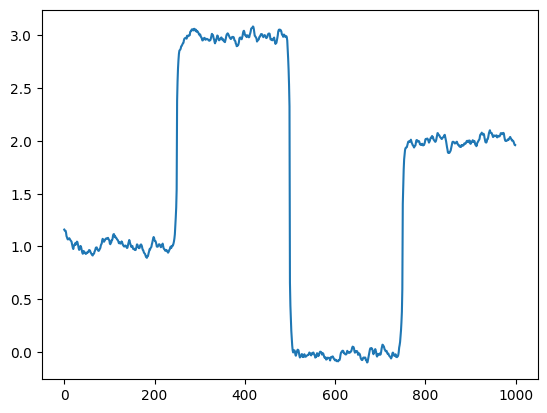

In [73]:
plt.plot(data["x"])
plt.show()

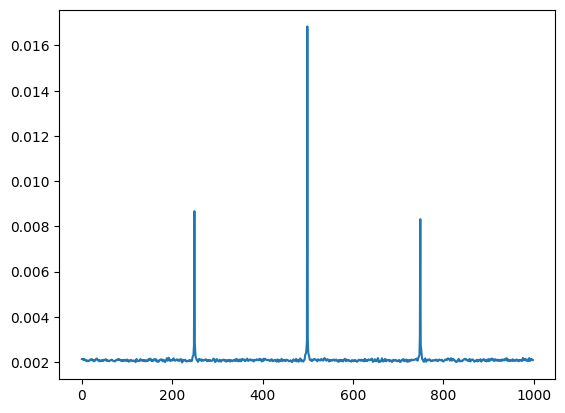

In [74]:
plt.plot(data["theta"])
plt.show()

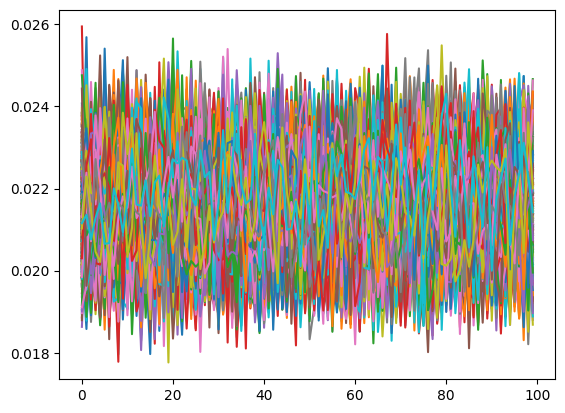

In [76]:
plt.plot(data["diag_post_cov_ests"])
plt.show()

In [104]:
data["theta"]

array([0.00213302, 0.00212188, 0.00211346, 0.00214522, 0.00212885,
       0.00208595, 0.00211561, 0.00211157, 0.00207687, 0.00206407,
       0.002081  , 0.00204137, 0.00203683, 0.00206582, 0.00204051,
       0.00204965, 0.00206355, 0.0020618 , 0.00209103, 0.00211381,
       0.00212662, 0.00209191, 0.00209236, 0.00212125, 0.00211344,
       0.00206445, 0.00203267, 0.00204577, 0.00209138, 0.00206347,
       0.00208179, 0.00213016, 0.0021447 , 0.00215837, 0.00210762,
       0.00210664, 0.00209405, 0.00204912, 0.00203807, 0.00209023,
       0.00206227, 0.00203357, 0.00205513, 0.00204437, 0.00207296,
       0.00209706, 0.00205784, 0.00204461, 0.00209044, 0.00210258,
       0.00209819, 0.00207739, 0.00209612, 0.00212821, 0.00208612,
       0.0020513 , 0.00208378, 0.00208141, 0.0020665 , 0.00205512,
       0.00203434, 0.00205398, 0.00206936, 0.00207046, 0.00208625,
       0.00208288, 0.00210532, 0.00209737, 0.00207374, 0.002054  ,
       0.00204215, 0.00205025, 0.00203576, 0.00202419, 0.00205

In [111]:
np.linalg.norm(data["theta"] - solver.theta_update(data["x"], data["diag_post_cov_ests"][-1,:]))

2.4426610224010136e-05

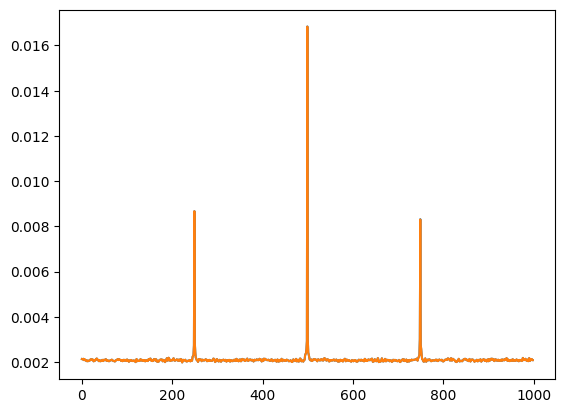

In [113]:
plt.plot(data["theta"])
plt.plot(solver.theta_update(data["x"], data["diag_post_cov_ests"][-1,:]))
plt.show()

In [122]:
np.linalg.norm( data["theta"] -  solver.theta_update(data["x"], data["diag_post_cov_ests"][-1,:]))

2.4426610224010136e-05

In [116]:
theta = data["theta"]
x = data["x"]
diag_est = data["diag_post_cov_ests"][-1,:]
r, beta, vartheta = hyperparams["prior"]["r"], hyperparams["prior"]["beta"], hyperparams["prior"]["vartheta"]

In [119]:
-0.5*(1.0/(theta)**2)*((solver.R @ x)**2) + (r/(vartheta**r))*(theta**(r-1)) - (r*beta - 1.5)*(1.0/theta)

array([4984.92422183, 4995.11526301, 4995.15722681, 4957.67613813,
       4877.71130034, 4984.65906217, 4971.16966038, 4991.4963789 ,
       4994.7825499 , 4994.38157702, 4989.09854929, 4991.27179369,
       4984.62768427, 4991.99814178, 4990.85885137, 4991.21586606,
       4937.12379889, 4960.36054964, 4945.42875836, 4983.41692287,
       4936.06083339, 4973.53561887, 4994.30978828, 4971.4988454 ,
       4972.03076995, 4988.8620177 , 4985.94480892, 4971.11026961,
       4994.37495077, 4952.59302037, 4953.27119734, 4930.74082859,
       4975.86680086, 4981.43371694, 4972.61056046, 4980.76002914,
       4992.11011594, 4938.54427531, 4953.32832657, 4956.26023254,
       4985.21703757, 4993.06505999, 4938.53974032, 4985.30590757,
       4989.81337986, 4990.96285747, 4991.69989404, 4981.18080801,
       4992.18091437, 4994.71372639, 4986.35097929, 4994.94619336,
       4995.18813247, 4979.1954771 , 4986.95903003, 4995.08958267,
       4992.7090848 , 4977.36244649, 4987.17333733, 4986.33995

# reference

In [92]:
hyperparams = {
}

_Rpinv = jlinops.MatrixLinearOperator(np.linalg.pinv(R.A.toarray()))
Rpinv_factory = lambda theta: _Rpinv @ jlinops.DiagonalOperator(np.sqrt(theta))

# def Rpinv_factory(theta):
#     Rtilde = jlinops.MatrixLinearOperator(sps.diags(1.0/np.sqrt(theta)) @ Rmat)
#     return jlinops.BandedCholeskyPinvOperator(Rtilde, delta=1e-8)

pdata = {
    "W": W,
    "Rpinv_factory": Rpinv_factory,
}

In [93]:
# Prior parameters
reg_lambda = 1e2
vartheta = 2/(reg_lambda**2)
hyperparams = {
    "prior": {
        "r": 1.0,
        "beta": 1.5 + 1e-2,
        "vartheta": vartheta,
    },
    # "noise_var": {
    #     "r": -1.0,
    #     "beta": 1,
    #     "vartheta": 1e-4,
    # }
}

# Create solver
solver = sampi.IASSolver(F, R, noisy_signal, hyperparams, noise_var=noise_var, pdata=pdata)

In [94]:
data = solver.solve(max_iters=100, priorconditioning=True, early_stopping=False, warmstarting=True, eps=1e-3)

In [95]:
data.keys()

dict_keys(['x', 'theta', 'n_cg_its_per_iteration', 'converged', 'obj_vals', 'noise_var', 'noise_vars', 'n_iters'])

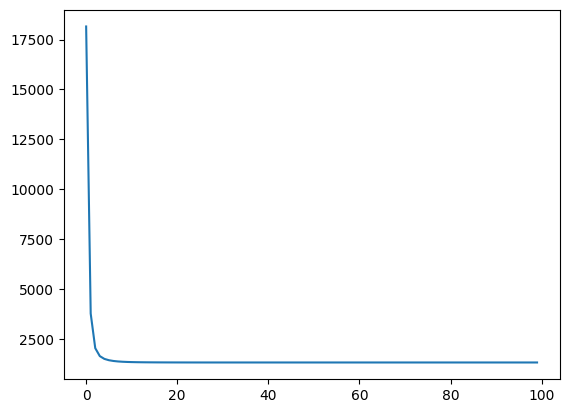

In [96]:
plt.plot(data["obj_vals"])
plt.show()

In [97]:
data.keys()

dict_keys(['x', 'theta', 'n_cg_its_per_iteration', 'converged', 'obj_vals', 'noise_var', 'noise_vars', 'n_iters'])

In [98]:
print(np.sum(data["n_cg_its_per_iteration"]))

115


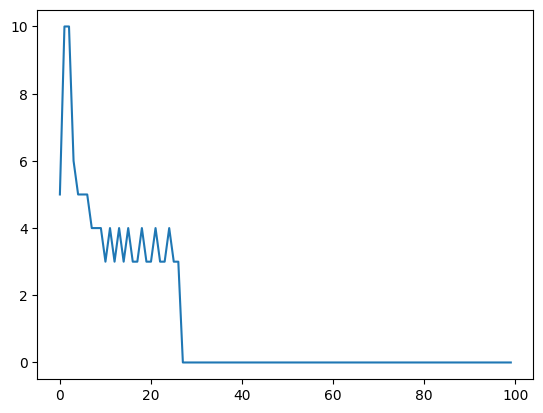

In [99]:
plt.plot(data["n_cg_its_per_iteration"])
plt.show()

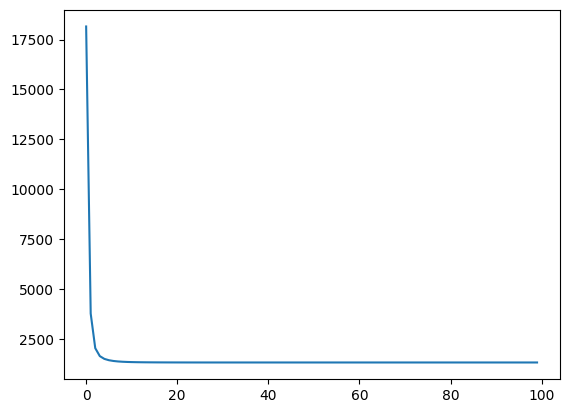

In [100]:
plt.plot(data["obj_vals"])
plt.show()

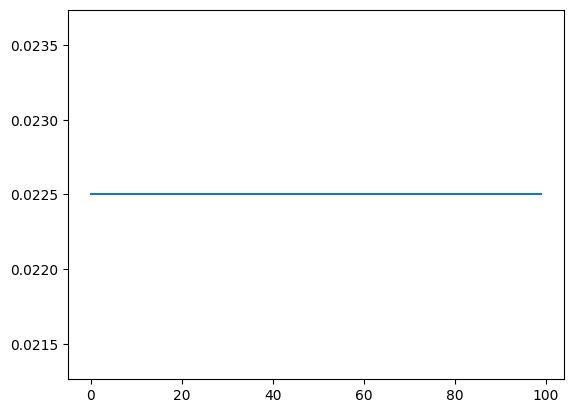

In [101]:
plt.plot(data["noise_vars"])
plt.show()

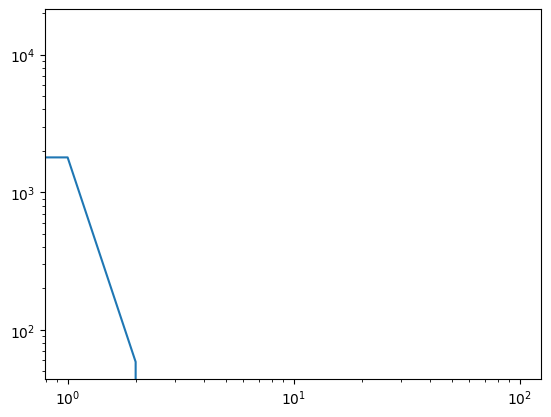

In [102]:
plt.loglog(data["obj_vals"] - 1.5*np.amin(data["obj_vals"]))
plt.show()

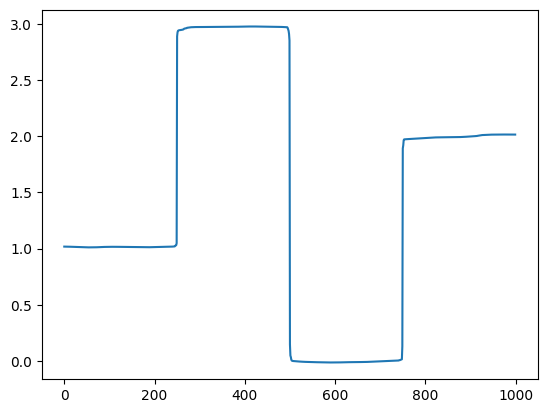

In [103]:
plt.plot(data["x"])
plt.show()

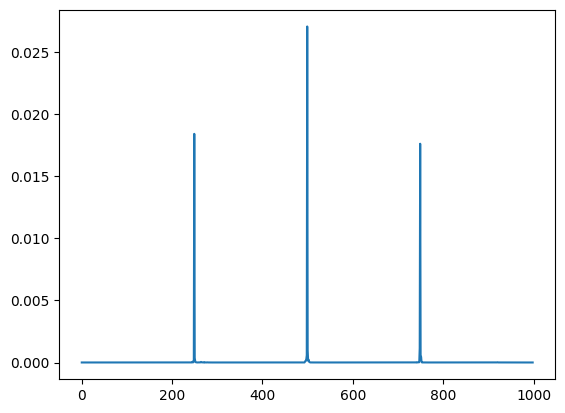

In [105]:
plt.plot(data["theta"])
plt.show()

In [104]:
data["noise_var"]

0.0225

In [17]:
noise_var

0.0225

# Transformed sampling

In [18]:
tsampler = sampi.PriorconditionedIASGaussianSampler(F, R, noisy_signal, data["theta"], pdata=pdata, noise_var=data["noise_var"])

In [32]:
tsdata = tsampler.sample(n_samples=1000, priorconditioning=True, warmstarting=True, tol=1e-1)

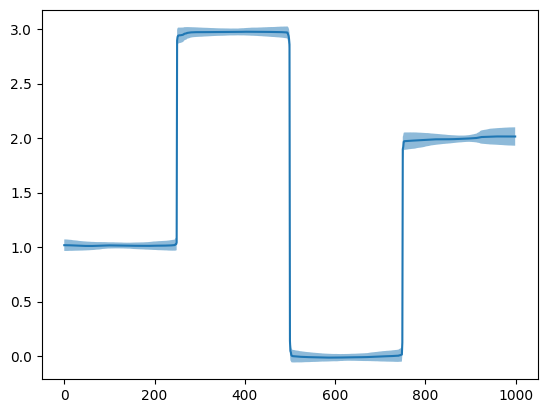

In [33]:
plt.plot(grid, tsdata["mean"])
sigmas = tsdata["stdev"]
plt.fill_between(grid, tsdata["mean"] - 3*sigmas, tsdata["mean"] + 3*sigmas, alpha=0.5)
plt.show()

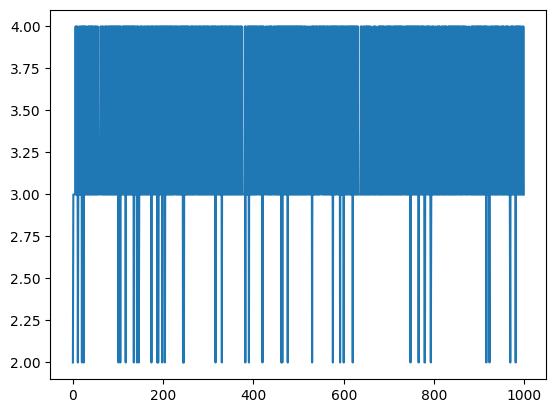

In [34]:
plt.plot(tsdata["n_cg_its_per_sample"])
plt.show()

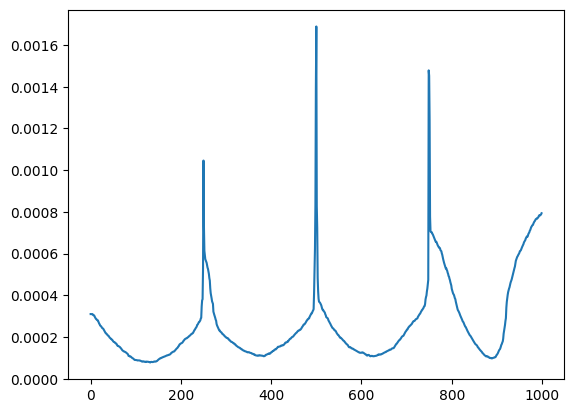

In [35]:
plt.plot(tsdata["var"])
plt.show()

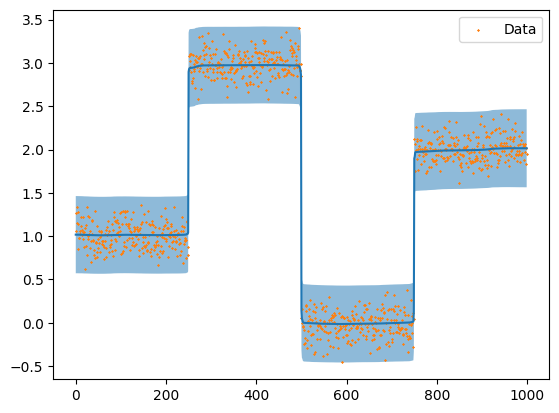

In [36]:
plt.plot(grid, tsdata["mean"])
marg_vars = tsdata["var"] + data["noise_var"]
sigmas = np.sqrt(marg_vars)
plt.fill_between(grid, tsdata["mean"] - 3*sigmas, tsdata["mean"] + 3*sigmas, alpha=0.5)
plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
plt.legend()
plt.show()

# Sample the posterior (condition on fixed hyperparameters)

In [54]:
# Build sampler
map_noise_var = data["noise_var"]
map_theta = data["theta"]
Ftilde = (1.0/np.sqrt(map_noise_var))*F
ytilde = (1.0/np.sqrt(map_noise_var))*noisy_signal
Rtilde = jlinops.DiagonalOperator(1.0/np.sqrt(map_theta)) @ R

factors = [Ftilde, Rtilde]
shifts = [ytilde, None]

In [55]:
sampler = sampi.CGLSGaussianSampler(factors, shifts)

In [56]:
sdata = sampler.sample(n_samples=100, warmstarting=True, tol=1e-7)

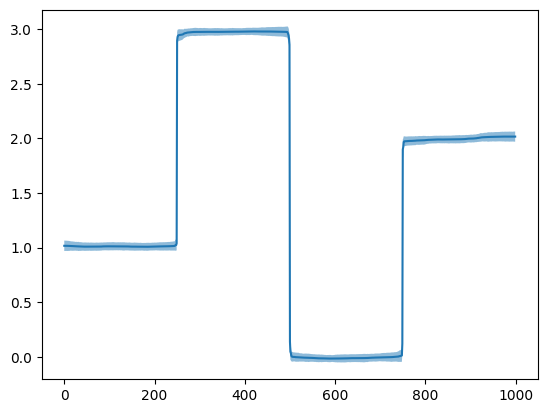

In [57]:
plt.plot(grid, sdata["mean"])
sigmas = sdata["stdev"]
plt.fill_between(grid, sdata["mean"] - 3*sigmas, sdata["mean"] + 3*sigmas, alpha=0.5)
plt.show()

In [58]:
sdata.keys()

dict_keys(['mean', 'stdev', 'var', 'n_cg_its_per_sample', 'tracker', 'obs_trackers'])

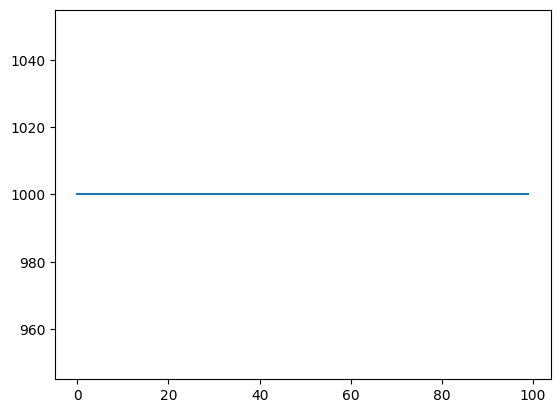

In [59]:
plt.plot(sdata["n_cg_its_per_sample"])
plt.show()

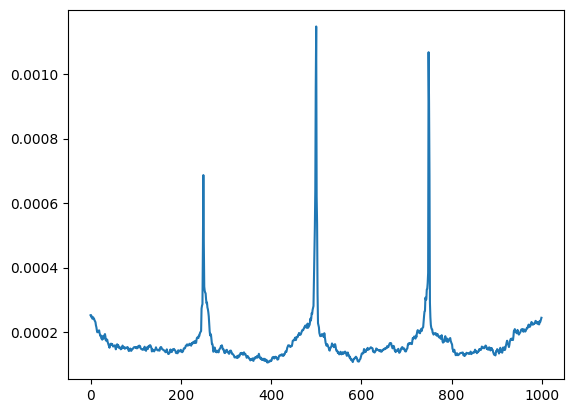

In [60]:
plt.plot(sdata["var"])
plt.show()

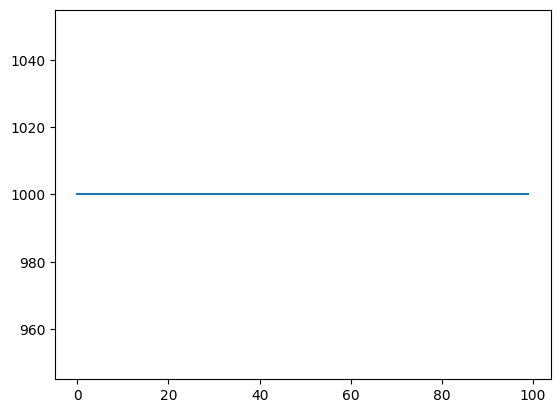

In [61]:
plt.plot(sdata["n_cg_its_per_sample"])
plt.show()

# Sample posterior predictive

In [23]:
post_pred_func = lambda z: z + np.sqrt(map_noise_var)*np.random.normal(size=z.shape)
#post_pred_func = lambda z: np.ones_like(z)

In [24]:
sampler = sampi.CGLSGaussianSampler(factors, shifts)

In [25]:
sdata = sampler.sample(n_samples=100, warmstarting=False, observables=[post_pred_func])

In [26]:
np.linalg.norm(sdata["tracker"].mean() - sdata["obs_trackers"][0].mean())

0.0

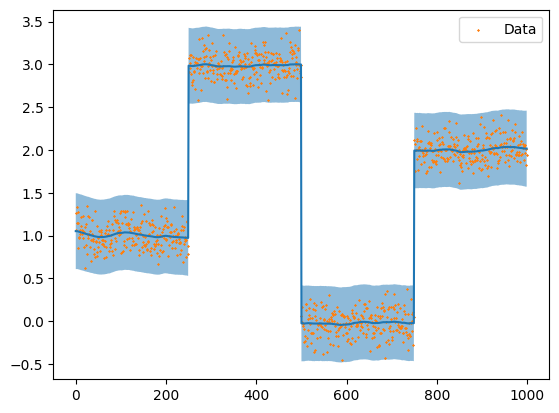

In [36]:
plt.plot(grid, sdata["mean"])
marg_vars = sdata["var"] + map_noise_var
sigmas = np.sqrt(marg_vars)
plt.fill_between(grid, sdata["mean"] - 3*sigmas, sdata["mean"] + 3*sigmas, alpha=0.5)
plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
plt.legend()
plt.show()

# Compare to LASSO?

In [18]:
lasso_sampler = sampi.BayesianLASSOGibbsSampler(F, R, noisy_signal, noise_var=noise_var, reg_lambda=reg_lambda)

In [19]:
lasso_result = lasso_sampler.sample(n_samples=1000, n_burn=500)

AttributeError: 'IdentityOperator' object has no attribute 'A'